In [2]:
!pip install -qU "OpenDSSDirect.py[extras]" --timeout 60

Starting Monte Carlo simulation with 1000 samples...
Generated 1000 load scenarios


100%|██████████| 1000/1000 [00:08<00:00, 113.21it/s]


Completed 1000 successful simulations

Voltage Profile Analysis:
Min voltage across all scenarios: 0.9449 pu
Max voltage across all scenarios: 1.0389 pu

Simulation complete. Generated 1000 samples for machine learning.
Data saved to 'main_dataset.csv'


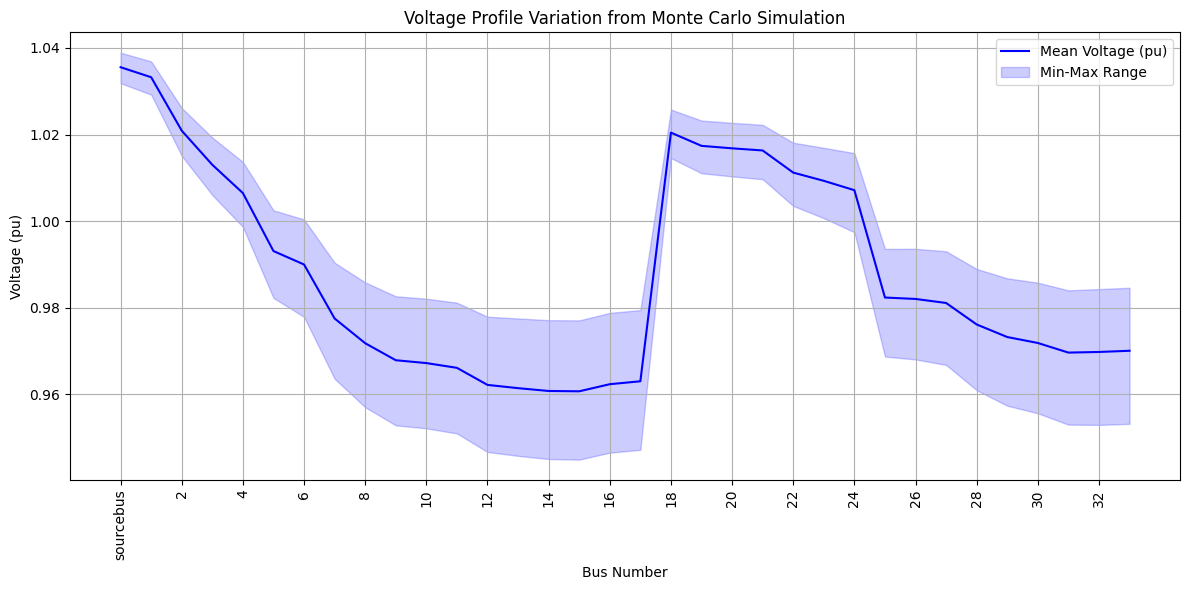

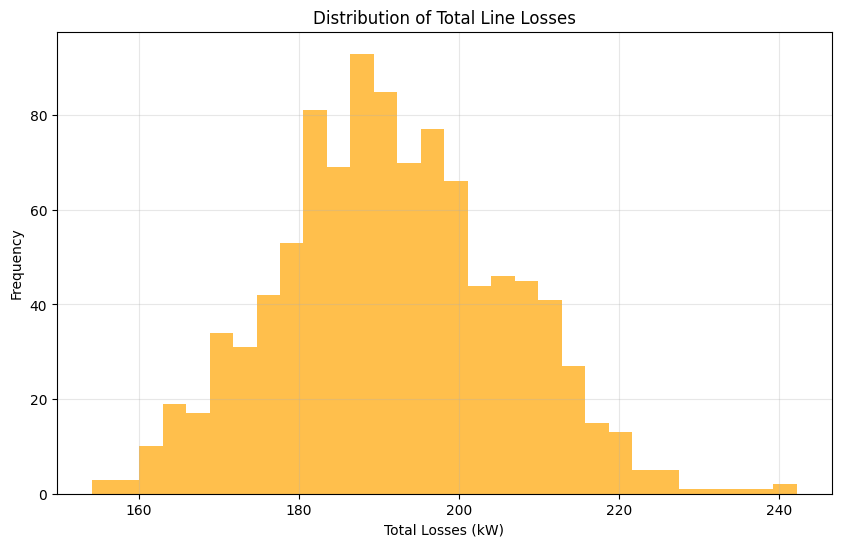

In [4]:
import opendssdirect as dss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class IEEE33BusMonteCarlo:
    def __init__(self, num_samples=1000):
        """Initialize the Monte Carlo simulation for IEEE 33-bus system"""
        self.num_samples = num_samples
        
        # Original line impedance data (per mile)
        self.line_data = [
            ('sourcebus', '1', 0.0922, 0.0477),
            ('1', '2', 0.4930, 0.2511),
            ('2', '3', 0.3660, 0.1864),
            ('3', '4', 0.3811, 0.1941),
            ('4', '5', 0.8190, 0.7070),
            ('5', '6', 0.1872, 0.6188),
            ('6', '7', 1.7114, 1.2351),
            ('7', '8', 1.0300, 0.7400),
            ('8', '9', 1.0400, 0.7400),
            ('9', '10', 0.1966, 0.0650),
            ('10', '11', 0.3744, 0.1238),
            ('11', '12', 1.4680, 0.1550),
            ('12', '13', 0.5416, 0.7129),
            ('13', '14', 0.5910, 0.5260),
            ('14', '15', 0.7463, 0.5450),
            ('15', '16', 1.2890, 1.7210),
            ('16', '17', 0.7320, 0.5740),
            ('2', '18', 0.1640, 0.0834),
            ('18', '19', 1.5042, 0.7694),
            ('19', '20', 0.4095, 0.2446),
            ('20', '21', 0.7089, 0.4178),
            ('3', '22', 0.4930, 0.2511),
            ('22', '23', 0.6380, 0.3246),
            ('23', '24', 0.8980, 0.2511),
            ('6', '25', 0.8960, 0.0952),
            ('25', '26', 0.2030, 0.3620),
            ('26', '27', 0.2842, 0.2511),
            ('27', '28', 1.0590, 0.1864),
            ('28', '29', 0.8042, 0.3216),
            ('29', '30', 0.5075, 0.1905),
            ('30', '31', 0.9744, 0.1864),
            ('31', '32', 0.3105, 0.2511),
            ('32', '33', 0.3410, 0.2615)
        ]
        
        # Original load data in kW and kVAR
        self.load_data = {
            '2': (100, 60),
            '3': (90, 40),
            '4': (120, 80),
            '5': (60, 30),
            '6': (60, 20),
            '7': (200, 100),
            '8': (200, 100),
            '9': (60, 20),
            '10': (60, 20),
            '11': (45, 30),
            '12': (60, 35),
            '13': (60, 35),
            '14': (120, 80),
            '15': (60, 10),
            '16': (60, 20),
            '17': (60, 20),
            '18': (90, 40),
            '19': (90, 40),
            '20': (90, 40),
            '21': (90, 40),
            '22': (90, 40),
            '23': (90, 50),
            '24': (420, 200),
            '25': (420, 200),
            '26': (60, 25),
            '27': (60, 25),
            '28': (60, 20),
            '29': (120, 80),
            '30': (200, 100),
            '31': (150, 70),
            '32': (210, 100),
            '33': (60, 40)
        }
        
        # Initialize capacitor locations
        self.capacitor_buses = ['17', '24', '30', '32', '33']
        
        # Database to store all simulation results
        self.simulation_results = []
        
    def generate_load_scenarios(self):
        """Generate Monte Carlo samples for load variations while preserving power factor"""
        load_scenarios = []
        
        for sample_id in range(self.num_samples):
            # Create a dictionary to store this scenario's loads
            scenario = {'sample_id': sample_id}
            
            # Generate random loads for each bus
            for bus, (p_mean, q_mean) in self.load_data.items():
                if p_mean == 0 and q_mean == 0:
                    # Skip buses with zero load
                    scenario[f'P_{bus}'] = 0
                    scenario[f'Q_{bus}'] = 0
                    continue
                
                # Calculate apparent power and power factor
                s_mean = np.sqrt(p_mean**2 + q_mean**2)
                pf = p_mean / s_mean
                theta = np.arccos(pf)
                
                # Define variability (standard deviation)
                # Using 15% of mean as standard deviation for realistic load variations
                p_std = 0.15 * p_mean
                
                # Generate random active power while ensuring it stays positive
                p_random = max(0.1, np.random.normal(loc=p_mean, scale=p_std))
                
                # Calculate reactive power maintaining the power factor
                q_random = p_random * np.tan(theta)
                
                # Store in scenario
                scenario[f'P_{bus}'] = p_random
                scenario[f'Q_{bus}'] = q_random
            
            load_scenarios.append(scenario)
            
        return pd.DataFrame(load_scenarios)
    
    def create_circuit(self, load_scenario=None):
        """Create the OpenDSS circuit with optional load scenario"""
        # Clear any existing circuits
        dss.Basic.ClearAll()

        # Create circuit with source parameters
        dss.Text.Command(
            'New Circuit.IEEE33Bus ' + 
            'bus1=sourcebus ' + 
            'basekv=12.66 ' + 
            'pu=1.05 ' +
            'phases=3 ' + 
            'MVAsc3=100 ' + 
            'MVAsc1=100'
        )

        # Set voltage bases
        dss.Text.Command('Set voltagebases=[12.66]')
        dss.Text.Command('Calcvoltagebases')

        # Add transmission lines
        for from_bus, to_bus, r, x in self.line_data:
            line_name = f"Line_{from_bus}_{to_bus}"
            dss.Text.Command(
                f"New Line.{line_name} " + 
                f"bus1={from_bus} " + 
                f"bus2={to_bus} " + 
                f"length=1 " + 
                f"units=mi " + 
                f"phases=3 " + 
                f"r1={r} " + 
                f"x1={x}"
            )

        # Add loads - either original or from scenario
        for bus in self.load_data.keys():
            if load_scenario is not None:
                p = load_scenario[f'P_{bus}']
                q = load_scenario[f'Q_{bus}']
            else:
                p, q = self.load_data[bus]
                
            dss.Text.Command(
                f"New Load.Load_{bus} " + 
                f"bus1={bus} " + 
                f"phases=3 " + 
                f"kV=12.66 " + 
                f"kW={p} " + 
                f"kvar={q} " + 
                f"model=1 " + 
                f"conn=wye"
            )

        # Add capacitors
        for bus in self.capacitor_buses:
            dss.Text.Command(
                f"New Capacitor.Cap_{bus} " +
                f"bus1={bus} " +
                f"phases=3 " +
                f"kvar=300 " +
                f"kV=12.66 " +
                f"conn=wye"
            )

        # Solution controls
        dss.Text.Command('Set maxiter=200')
        dss.Text.Command('Set tolerance=0.0001')
    
    def solve_and_get_results(self, sample_id=None, load_scenario=None):
        """Solve circuit and extract results for a specific scenario"""
        try:
            dss.Text.Command('Solve')
            
            if not dss.Solution.Converged():
                print(f"Warning: Solution did not converge for sample {sample_id}")
                return None
                
            # Extract voltage results
            results = {'sample_id': sample_id} if sample_id is not None else {}
            
            # Get voltage results for all buses
            bus_names = dss.Circuit.AllBusNames()
            base_voltage = 12660.0  # Base voltage in volts
            
            for bus in bus_names:
                dss.Circuit.SetActiveBus(bus)
                vmag = dss.Bus.VMagAngle()[0::2]
                vang = dss.Bus.VMagAngle()[1::2]
                
                if vmag and len(vmag) > 0:
                    # Store voltage magnitude in per unit
                    results[f'V_{bus}'] = vmag[0] / (base_voltage / np.sqrt(3))
                    results[f'Angle_{bus}'] = vang[0] if vang else 0
            
            # Get line losses
            line_losses = dss.Circuit.LineLosses()
            results['total_losses_kw'] = line_losses[0]
            
            # Add load scenario data if provided
            if load_scenario is not None:
                for key, value in load_scenario.items():
                    if key != 'sample_id':  # Avoid duplicate sample_id
                        results[key] = value
            
            return results
            
        except Exception as e:
            print(f"Error solving circuit: {e}")
            return None
    
    def run_monte_carlo(self):
        """Execute Monte Carlo simulation with many load scenarios"""
        print(f"Starting Monte Carlo simulation with {self.num_samples} samples...")
        
        # Generate all load scenarios
        scenarios_df = self.generate_load_scenarios()
        scenarios_df.to_csv('./generated_datasets/load_scenarios.csv', index=False)
        print(f"Generated {len(scenarios_df)} load scenarios")
        
        # Run simulation for each scenario
        for _, scenario in tqdm(scenarios_df.iterrows(), total=len(scenarios_df)):
            # Create circuit with this scenario's loads
            self.create_circuit(scenario)
            
            # Solve and get results
            results = self.solve_and_get_results(scenario['sample_id'], scenario)
            
            if results:
                self.simulation_results.append(results)
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(self.simulation_results)
        
        # Save results
        results_df.to_csv('./generated_datasets/monte_carlo_results.csv', index=False)
        print(f"Completed {len(results_df)} successful simulations")
        
        return results_df
    
    def analyze_results(self, results_df):
        """Analyze and visualize Monte Carlo simulation results"""
        # Extract bus voltage data for easier analysis
        voltage_columns = [col for col in results_df.columns if col.startswith('V_')]
        voltage_df = results_df[voltage_columns]
        
        # Summary statistics
        voltage_stats = voltage_df.describe()
        voltage_stats.to_csv('./generated_datasets/voltage_statistics.csv')
        
        # Create min, max, mean voltage profile plot
        plt.figure(figsize=(12, 6))
        
        # Get bus names from column names
        buses = [col.split('_')[1] for col in voltage_columns]
        
        # Sort buses numerically (with special handling for 'sourcebus')
        def bus_sort_key(bus):
            if bus == 'sourcebus':
                return -1
            return int(bus) if bus.isdigit() else float('inf')
        
        sorted_indices = sorted(range(len(buses)), key=lambda i: bus_sort_key(buses[i]))
        sorted_buses = [buses[i] for i in sorted_indices]
        sorted_columns = [voltage_columns[i] for i in sorted_indices]
        
        # Calculate statistics
        mean_voltages = voltage_df[sorted_columns].mean().values
        min_voltages = voltage_df[sorted_columns].min().values
        max_voltages = voltage_df[sorted_columns].max().values
        
        # Create x-axis with proper bus ordering
        x = np.arange(len(sorted_buses))
        
        # Plot
        plt.plot(x, mean_voltages, 'b-', label='Mean Voltage (pu)')
        plt.fill_between(x, min_voltages, max_voltages, alpha=0.2, color='blue', label='Min-Max Range')
        
        plt.title('Voltage Profile Variation from Monte Carlo Simulation')
        plt.xlabel('Bus Number')
        plt.ylabel('Voltage (pu)')
        plt.grid(True)
        
        # Set x-ticks to bus names with some spacing
        plt.xticks(x[::2], [sorted_buses[i] for i in range(0, len(sorted_buses), 2)], rotation=90)
        
        plt.legend()
        plt.tight_layout()
        plt.savefig('./visualizations/voltage_profile.png', dpi=300)
        
        # Also plot total losses distribution
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['total_losses_kw'], bins=30, color='orange', alpha=0.7)
        plt.title('Distribution of Total Line Losses')
        plt.xlabel('Total Losses (kW)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.savefig('./visualizations/losses_distribution.png', dpi=300)
        
        print("\nVoltage Profile Analysis:")
        print(f"Min voltage across all scenarios: {voltage_df.values.min():.4f} pu")
        print(f"Max voltage across all scenarios: {voltage_df.values.max():.4f} pu")
        
        ml_ready_data = results_df.copy()
        ml_ready_data.to_csv('./generated_datasets/main.csv', index=False)
        
        return voltage_stats, ml_ready_data

if __name__ == "__main__":
    num_samples = 1000  
    mc_sim = IEEE33BusMonteCarlo(num_samples)
    results = mc_sim.run_monte_carlo()
    stats, ml_data = mc_sim.analyze_results(results)
    
    print(f"\nSimulation complete. Generated {len(ml_data)} samples for machine learning.")
    print(f"Data saved to 'main_dataset.csv'")